# Tests for Energy Drifts

While the system is supposed to be Hamiltonian, it is possible that imprecise numeric calcualtions slowly drift the energy. The goal of this notebook is to check that. 

Found 1000 files. Processing...


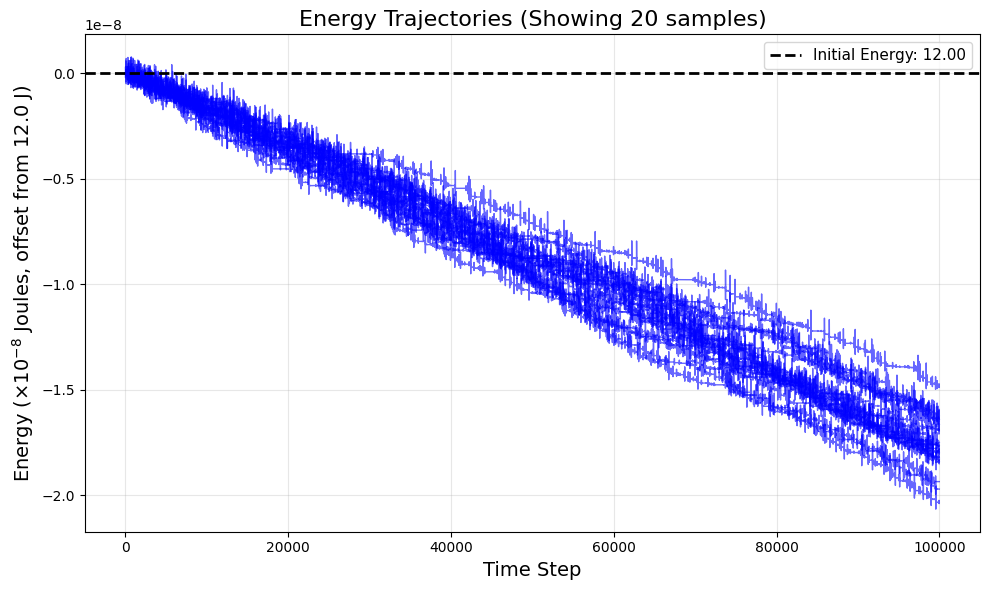

In [9]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class PendulumParams:
    G: float = 9.8
    L1: float = 2.0
    L2: float = 2.0
    M1: float = 1.0
    M2: float = 1.0
    t_stop: float = 1000.0
    dt: float = 0.01

    @property
    def total_length(self) -> float:
        return self.L1 + self.L2

def verify_energy(th1, w1, th2, w2, params: PendulumParams):
    """Function that checks the energy of a pendulum given its state"""
    # Accessing attributes from the class or instance
    m1, m2 = params.M1, params.M2
    l1, l2 = params.L1, params.L2
    g = params.G
    M = m1 + m2

    # Potential Energy
    V = -M * g * l1 * np.cos(th1) - m2 * g * l2 * np.cos(th2)

    # Kinetic Energy
    T = (0.5 * M * (l1**2) * (w1**2) + 
         0.5 * m2 * (l2**2) * (w2**2) + 
         m2 * l1 * l2 * w1 * w2 * np.cos(th1 - th2))

    E = V + T
    return E, 

# --- Main Processing Logic ---

search_dir = "paths1"
search_pattern = os.path.join(search_dir, "*.csv")
csv_files = glob.glob(search_pattern)

if not csv_files:
    print(f"Error: No .csv files found in directory '{search_dir}/'")
else:
    print(f"Found {len(csv_files)} files. Processing...")

    # Configuration
    N_PLOTTED = 20
    
    # Storage
    plotted_traces = []   # To store full energy arrays for the plot
    all_energy_diffs = [] # To store (Final - Initial) energy for ALL files

    for i, file_path in enumerate(csv_files):
        try:
            # Read CSV (assuming consistent columns)
            df = pd.read_csv(file_path)
            
            # Ensure we have enough data columns
            if len(df.columns) < 4:
                continue

            # Map columns
            th1 = df.iloc[:, 0].values
            w1  = df.iloc[:, 1].values
            th2 = df.iloc[:, 2].values
            w2  = df.iloc[:, 3].values

            # Helper to get energy at a specific index
            def get_energy_at_index(idx):
                return verify_energy(th1[idx], w1[idx], th2[idx], w2[idx], PendulumParams)[0]

            # 1. Calculate Difference for Box Plot (ALL files)
            e_initial = get_energy_at_index(0)
            e_final = get_energy_at_index(-1)
            diff = e_final - e_initial
            all_energy_diffs.append(diff)

            # 2. Store Full Trajectory only for the first N_PLOTTED files
            if i < N_PLOTTED:
                # Calculate energy for every step
                trace = [verify_energy(th1[k], w1[k], th2[k], w2[k], PendulumParams)[0] 
                         for k in range(len(df))]
                plotted_traces.append(trace)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    # --- Plotting ---

    # Plot 1: Energy Trajectories
    fig, ax = plt.subplots(figsize=(10, 6))

    # Average initial energy (plotted paths only)
    if plotted_traces:
        initial_energies = [t[0] for t in plotted_traces]
        avg_initial_e = np.mean(initial_energies)

    # Plot the stored traces
    for trace in plotted_traces:
        ax.plot(trace - avg_initial_e, linewidth=1.0, alpha=0.6, color='blue')

    ax.axhline(
        0,
        color='black',
        linestyle='--',
        linewidth=2,
        label=f'Initial Energy: {avg_initial_e:.2f}'
    )

    # ---- Axis formatting fixes ----
    # ax.ticklabel_format(axis='y', style='plain', useOffset=False)

    ax.set_xlabel("Time Step", fontsize=14)
    ax.set_ylabel(r"Energy ($\times 10^{-8}$ Joules, offset from 12.0 J)", fontsize=14)
    ax.set_title(
        f"Energy Trajectories (Showing {len(plotted_traces)} samples)",
        fontsize=16
    )

    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


    # Plot 2: Box Plot of Differences (New Window/Figure)
    # plt.figure(figsize=(8, 6))
    # plt.boxplot(all_energy_diffs, vert=True, patch_artist=True)
    # plt.title(f"Distribution of Energy Drift (Final - Initial)\nSample Size: {len(all_energy_diffs)}")
    # plt.ylabel("Energy Difference (Joules)")
    # plt.grid(True, alpha=0.3)
    # plt.tight_layout()
    # plt.show()

    # # --- Print Statistics ---
    # print("\nStatistics for Energy Differences (Final - Initial):")
    # stats = pd.Series(all_energy_diffs).describe()
    # print(stats)

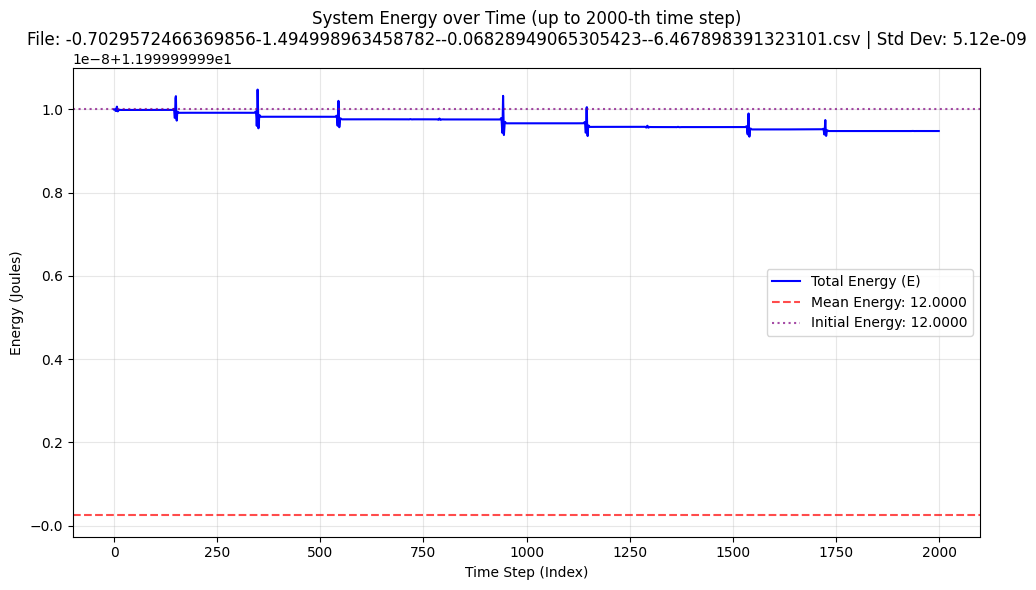

In [ ]:
# DEFUNCT

plt.figure(figsize=(10, 6))

plot_up_to = 2000

# Plot the Total Energy
plt.plot(total_energy[:plot_up_to], label='Total Energy (E)', color='blue', linewidth=1.5)

# Calculate statistics for the title
mean_e = np.mean(total_energy)
std_e = np.std(total_energy)

# Add a reference line for the mean energy
plt.axhline(mean_e, color='red', linestyle='--', alpha=0.7, label=f'Mean Energy: {mean_e:.4f}')
plt.axhline(total_energy[0][0], color='purple', linestyle=':', alpha=0.7, label=f'Initial Energy: {total_energy[0][0]:.4f}')


plt.title(f"System Energy over Time (up to {plot_up_to}-th time step)\nFile: {os.path.basename(target_file)} | Std Dev: {std_e:.2e}")
plt.xlabel("Time Step (Index)")
plt.ylabel("Energy (Joules)")
plt.legend()
plt.grid(True, alpha=0.3)

# Adjust layout and show
plt.tight_layout()
plt.show()

In [67]:
print(f"Mean over time: {mean_e}")
print(f"Difference from the initial value: {total_energy[0][0]-mean_e}")

Mean over time: 11.99999999108079
Difference from the initial value: 8.919203153823219e-09


Both from the graph and from the values above, it is clearly visible that the energy dissipitation is, first, linear and, second, on the order of $e-09$, i.e., negligible. 

## Sanity Checks

In [61]:
print(th1[0], w1[0], th2[0], w2[0])
print(verify_energy(th1[0], w1[0], th2[0], w2[0], PendulumParams)[0])
print(total_energy[0][0], total_energy[1][0])

-0.8704844266360975 -1.5655113064506052 1.6065962967293943 2.627359514211462
11.999999999999993
11.999999999999993 11.999999999999993
